In [1]:
from HeaderP import *
import pynbody as pb
import pynbody.filt as filt
import os, pickle, glob


In [2]:
sims = os.listdir('./')
sims = [i for i in sims if 'x' in i]
sims = [i for i in sims if '.txt' not in i]
sims = [i for i in sims if '.pkl' not in i]
simsnames = [i.split('_')[0][1:] for i in sims]



In [3]:
from itertools import combinations_with_replacement
import matplotlib
from scipy import interpolate
from scipy.interpolate import interp1d
import matplotlib as mpl
def getcolor(vrange,cm=plt.cm.get_cmap('viridis')):
    cmap = cm
    norm = matplotlib.colors.Normalize(vmin=min(vrange[:-1]), vmax=max(vrange[:-1]))
    return [cmap(norm(i)) for i in vrange]



# get true slope
def getISMevolution(ISMdata, numofbins=15):
    agebin = np.linspace(min(ISMdata['time']),max(ISMdata['time']),numofbins+1)
    slopes_ism = np.zeros(len(agebin)-1)
    splitR = np.linspace(0,10,6)
    ismcols = ISMdata.columns[1:]
    strres = np.zeros(len(agebin)-1)
    for i in range(len(agebin)-1):
        feh_ism=np.zeros(len(splitR)-1)
        for j in range(len(splitR)-1):
            m = ((ISMdata['time']>agebin[i])&(ISMdata['time']<agebin[i+1]))
            feh_ism[j] = np.mean(ISMdata[ismcols[j]][m].dropna())
        z, strres[i] = np.polyfit(splitR[:-1]+np.diff(splitR)[0], feh_ism, 1, full=True)[:2]
        p = np.poly1d(z)
        slopes_ism[i]=p[1]

    f_slope = interpolate.interp1d((agebin[:-1]+np.diff(agebin)[0]/2),slopes_ism, kind='cubic')
    f_feh = interpolate.interp1d(ISMdata['time'],ISMdata[ismcols[-2]])
    return agebin[:-1]+np.diff(agebin)[0]/2, f_slope, f_feh, strres




def readsimdata(simNo,Rcut,Rcut_thread,zcut_thread,disk=True):
    if disk:
        data=pd.read_pickle('./'+simNo+'_z_0_decomp.pkl')
    else:
        data=pd.read_pickle('./'+simNo+'_z_0.pkl')
    data['R']=np.sqrt((data['x'])**2+data['y']**2)
    
    if Rcut:
        data=data.loc[data['Rbir']<Rcut_thread].reset_index(drop=True)
        data=data.loc[abs(data['zbir'])<zcut_thread].reset_index(drop=True)
    data['dR']=data['R']-data['Rbir']
    data['dz']=abs(data['z'])-abs(data['zbir'])
    return data

def calcISM(sim, splitR=np.linspace(0,10,6), disk=False):
    
    print(sim)
    simsname = sim.split('_')[0]
    allsnaps = glob.glob(sim+'/*.?????')
    
    allsnaps_time = [int(i.split('.')[-1]) for i in allsnaps if (('param' not in i) and ('draco' not in i) and ('dat_' not in i) and ('79e12' not in i.split('.')[-1]))]
    snaplookup = {int(allsnaps[i].split('.')[-1]):allsnaps[i] for i in range(len(allsnaps)) if (('param' not in allsnaps[i]) and ('draco' not in allsnaps[i]) and ('dat_' not in allsnaps[i]) and ('79e12' not in allsnaps[i].split('.')[-1]))}

    allsnaps_time = sorted(allsnaps_time)
    
    if disk:
        f = open(simsname+'_ISM_disk.txt', "w")
        f_w = open(simsname+'_weights_disk.txt', "w")
    else:
        f = open(simsname+'_ISM.txt', "w")
        f_w = open(simsname+'_weights.txt', "w")
    headerf = 'time,'
    for i in range(len(splitR)-1):
        rbin = str(splitR[i])+'-'+str(splitR[i+1])
        if i == len(splitR)-2:
             headerf = headerf+rbin+'\n'
        else:
            headerf = headerf+rbin+','
    f.write(headerf)
    f.flush()
    
    
    simNo=simsname
    Rcut=True
    Rcut_thread=30
    zcut_thread=5

    print('Reading in simulation...')
    data_z0 = readsimdata(simNo,Rcut,Rcut_thread,zcut_thread,disk=disk)
    print('Finished reading in simulation...')
    
    
    count=0
    for i in trange(len(allsnaps_time)):
        s = pb.load(snaplookup[allsnaps_time[i]])
        s.physical_units()
        ages = s.properties['time']
        h=s.halos()
        try:
            h[1]
        except:
            print("Can't find halo for snapshot "+snaplookup[allsnaps_time[i]])
            continue
        pb.analysis.angmom.faceon(h[1])

        gal = pb.filt.LowPass('r', '25 kpc') & pb.filt.BandPass('z', '-2.5 kpc', '2.5 kpc')
        sim = h[1][gal]
    
        stars = sim.g
        
        if len(stars)==0:
            print('No stars in this snapshot!')
            continue
        
        cols = ['feh','x','y']
        try:
            this_snap = {j:stars[j] for j in cols}
        except:
            print('No gas')
            continue
    
        data = pd.DataFrame(this_snap)
        data['R'] = np.sqrt(data['x']**2+data['y']**2)
        data = data.dropna(subset=['feh'])
        
        nextlinef = str(ages).split(' ')[0]
        for j in range(len(splitR)-1):
            locstar = data.loc[(data['R']>splitR[j])&(data['R']<splitR[j+1])].reset_index(drop=True)
            nextlinef = nextlinef+','+str(np.mean(locstar['feh']))
        print(nextlinef)
        f.write(nextlinef+'\n')
        f.flush()
        
        ############################ analyze stars ############################
        stars = sim.s
        cols = ['feh','x','y','iord']
        try:
            this_snap = {j:stars[j] for j in cols}
        except:
            print('No stars')
            continue
        if len(stars)<1000:
            print('Not enough stars!')
            continue
        data = pd.DataFrame(this_snap)
        data['R'] = np.sqrt(data['x']**2+data['y']**2)
        data = data.dropna(subset=['feh'])
        data = pd.merge(data, data_z0[['Rbir', 'age', 'iord']], 
                        left_on='iord', right_on='iord',how='inner')
        
        
        #print('Calculating weights...')
        try:
            allnames, weights, weights_err, y, ypred = calcRbir_cv(data)
            scat = np.std(y-ypred)
            bias  = np.mean(y-ypred)
        except:
            print("can't get weights for feh and age!")
            continue
        #print(len(allnames), len(weights))
        #print('Finished calculating weights...')
        
            
        #print('Calculating weights with R...')
        try:
            allnames_wR, weights_wR, weights_err_wR, y_wR, ypred_wR = calcRbir_cv_withR(data)
            scat_wR = np.std(y_wR-ypred_wR)
            bias_wR  = np.mean(y_wR-ypred_wR)
        except:
            print("can't get weights for feh, R, and age!")
            continue
        #print('Finished calculating weights...')

        if count==0:
            firstline = 'time'
            for kk in range(len(allnames)):
                firstline = firstline+','+allnames[kk]
                firstline = firstline+','+allnames[kk]+'_err'
                
            for kk in range(len(allnames_wR)):
                firstline = firstline+','+allnames_wR[kk]+'_wR'
                firstline = firstline+','+allnames_wR[kk]+'_wR_err'
            firstline = firstline+','+'scatter,bias,scatter_err,bias_err\n'
            
            f_w.write(firstline)
            f_w.flush()
            count=count+1
            continue
        
        linewrite = str(ages).split(' ')[0]
        for kk in range(len(allnames)):
            linewrite = linewrite+','+str(weights[kk])
            linewrite = linewrite+','+str(weights_err[kk])

        for kk in range(len(allnames_wR)):
            linewrite = linewrite+','+str(weights_wR[kk])
            linewrite = linewrite+','+str(weights_err_wR[kk])
        linewrite = linewrite+','+str(scat)+','+str(bias)+','+str(scat_wR)+','+str(bias_wR)+'\n'
        f_w.write(linewrite)
        f_w.flush() 
            

In [82]:
import matplotlib as mpl
def objective(x, a, b, c):
    return a * x + b
    
def pltFehR_ISM(time2snap, cosmictime, pltfeh=True, figname=None, ylim=[-2.5,0.5]):
    allage_times = np.array(list(time2snap.keys()), dtype=float)
    get_time = abs(allage_times-cosmictime)
    get_time, ind = zip(*sorted(zip(get_time, range(len(get_time)))))
    snap = time2snap[allage_times[ind[0]]]
    #print('closest time is:', allage_times[ind[0]])
    #print('reading snap', snap)
    
    try:
        data = pd.read_pickle(snap+'_gas.pkl')
    except:
        s = pb.load(snap)
        s.physical_units()

        h=s.halos()
        try:
            pb.analysis.angmom.faceon(h[1])
        except:
            print('no halo!')
            return np.nan

        gal = pb.filt.LowPass('r', '25 kpc') & pb.filt.BandPass('z', '-2.5 kpc', '2.5 kpc')
        sim = h[1][gal]

        gas = sim.g

        if len(gas)==0:
            return np.nan

        cols = ['feh','x','y']
        try:
            data = pd.DataFrame({j:gas[j] for j in cols})
        except:
            print('no gas!')
            return np.nan

        data['R'] = np.sqrt(data['x']**2+data['y']**2)
        data.to_pickle(snap+'_gas.pkl')
        
    if pltfeh:
        mpl.rcParams['agg.path.chunksize'] = len(data)+1e5
        plt.figure(figsize=(20,8))
        plt.subplot(1,2,1)
        plt.hexbin(data['x'],data['y'],gridsize=100,extent=(-15,15,-15,15),mincnt=1,
                   cmap=plt.cm.get_cmap('binary'), vmin=0, vmax=500)
        plt.xlabel('x [kpc]')
        plt.ylabel('y [kpc]')
        plt.xlim([-15,15])
        plt.ylim([-15,15])
        cb = plt.colorbar()
        cb.set_label('Density')
        plt.title(snap+' at time %.2f'%(allage_times[ind[0]])+' Gyr',fontsize=25)

        plt.subplot(1,2,2)
        plt.plot(data['R'],data['feh'], 'r.', alpha=0.1, markersize=1)
        rmed, fehmed = movingMed_time(data['R'].values,data['feh'].values,0.5,1)
        """
        plt.hexbin(data['R'],data['feh'],extent=(0,15,ylim[0], ylim[1]), 
                   gridsize=30, cmap=plt.cm.get_cmap('binary'),
                  mincnt=1, vmin=0, vmax=7000)
        """
        p = fitpoints(rmed, fehmed)
        plt.plot([min(rmed),max(rmed)], p([min(rmed),max(rmed)]), 'k-')
        plt.xlabel('R [kpc]')
        plt.ylabel('[Fe/H]')
        plt.ylim(ylim)
        plt.xlim([0,15])
        #cb = plt.colorbar()
        #cb.set_label('Density')
        plt.title('Slope of metallicity is: %.5f'%(p[1]),fontsize=25)
        plt.scatter(rmed, fehmed, s=10, c='k')
        plt.tight_layout()
        if figname!=None:
            plt.savefig(figname)
    else:
        rmed, fehmed = movingMed_time(data['R'].values,data['feh'].values,0.5,1)
        z = np.polyfit(rmed, fehmed, 1, full=True)
        p = np.poly1d(z[0])
        res = z[1][0]
        pl = len(data['R'])
        return p[1], res, pl
    

In [7]:
# get all slopes
for i in range(len(sims)):
    sim = sims[i]
    print(sim)
    simsname = sim.split('_')[0]
    allsnaps = glob.glob(sim+'/*.?????')

    allsnaps_time = [int(i.split('.')[-1]) for i in allsnaps if (('param' not in i) and ('draco' not in i) and ('dat_' not in i) and ('79e12' not in i.split('.')[-1]))]
    snaplookup = {int(allsnaps[i].split('.')[-1]):allsnaps[i] for i in range(len(allsnaps)) if (('param' not in allsnaps[i]) and ('draco' not in allsnaps[i]) and ('dat_' not in allsnaps[i]) and ('79e12' not in allsnaps[i].split('.')[-1]))}

    allsnaps_time = sorted(allsnaps_time)
    allages_ism = np.zeros(len(allsnaps_time))

    for j in trange(len(allsnaps_time)):
        s = pb.load(snaplookup[allsnaps_time[j]])
        s.physical_units()
        allages_ism[j] = s.properties['time']

    time2snap = {allages_ism[ii]:snaplookup[allsnaps_time[ii]] for ii in range(len(allsnaps_time))}
    
    
    allage_times_calc = np.array(list(time2snap.keys()), dtype=float)
    slopes = np.zeros(len(allage_times_calc))
    res = np.zeros(len(allage_times_calc))
    pls = np.zeros(len(allage_times_calc))
    for j in trange(len(allage_times_calc)):
        try:
            slopes[j], res[j], pls[j] = pltFehR_ISM(time2snap, allage_times_calc[j], pltfeh=False)
        except:
            slopes[j], res[j], pls[j] = np.nan, np.nan, np.nan
    
    name = ''
    for k in sims[i].split('_')[0].split('.'):
        name = name+k
    (pd.DataFrame(np.array((allage_times_calc, slopes, res, pls)).T,columns=['time','slope','residual', 'gp_no'])).to_pickle('ISM_slope_'+name+'.pkl')

        
        

g6.96e11_3x9


  6%|▋         | 8/128 [00:00<00:03, 36.75it/s]

no halo!


100%|██████████| 128/128 [00:30<00:00,  4.23it/s]


g8.26e11_2x4x8


  1%|          | 1/180 [00:00<00:42,  4.26it/s]

no halo!


  4%|▍         | 7/180 [00:31<10:09,  3.52s/it]

no gas!


 19%|█▉        | 35/180 [01:22<24:17, 10.05s/it]

no gas!


100%|██████████| 180/180 [02:02<00:00,  1.47it/s]


g7.08e11_5x10


  4%|▍         | 6/160 [00:00<00:10, 14.60it/s]

no halo!


100%|██████████| 160/160 [02:37<00:00,  1.02it/s] 


g1.12e12_3x9


  4%|▍         | 8/184 [00:00<00:05, 30.70it/s]

no halo!


100%|██████████| 184/184 [4:39:04<00:00, 91.00s/it]   


g2.79e12_3x6


  0%|          | 1/228 [00:00<01:14,  3.04it/s]

no halo!


  1%|          | 2/228 [00:00<01:08,  3.31it/s]

no halo!


  4%|▎         | 8/228 [00:46<18:15,  4.98s/it]  

no gas!


100%|██████████| 228/228 [10:01:00<00:00, 158.16s/it]  


g7.55e11_3x9


  5%|▍         | 6/128 [00:00<00:07, 15.37it/s]

no halo!


100%|██████████| 128/128 [01:41<00:00,  1.26it/s]


# Show how Minchev, Frankel+ methods breakdown

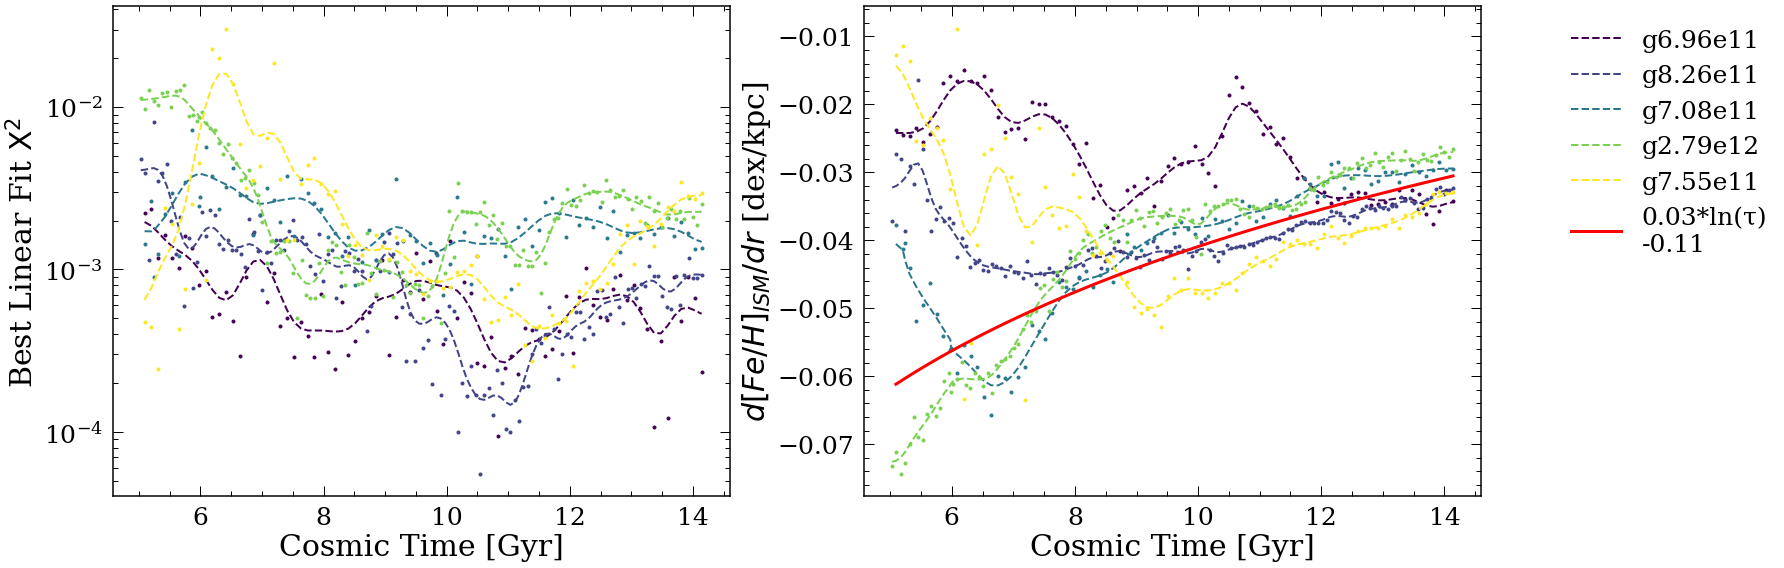

In [114]:
from scipy.optimize import curve_fit
from scipy.ndimage import gaussian_filter1d
colors = getcolor(range(7))

def loge(x, a, b):
    return a*np.log(x)+b

plt.figure(figsize=(25,8))
plt.subplot(1,2,2)
for i in range(len(sims)):
    name = ''
    for k in sims[i].split('_')[0].split('.'):
        name = name+k
    if name == 'g112e12':
        continue
    df = pd.read_pickle('ISM_slope_'+name+'.pkl')
    name = name[:2]+'.'+name[2:]
    
    m=df['time']>5
    df = df[m].reset_index(drop=True)
    
    plt.plot(df['time'].values, df['slope'].values,'.',color=colors[i])
    slopes = gaussian_filter1d(df['slope'].values, 2)
    plt.plot(df['time'].values, slopes,'--',label=name,color=colors[i])
    
    """
    m = df['time']>10
    popt, pcov = curve_fit(loge, df['time'].values[m], df['time'].values[m],
                           bounds=[[0,-10],[0.5,1]])
    print(popt)
    """
plt.plot(df['time'].values, loge(df['time'].values,0.03,-0.11),'r-',linewidth=3,
        label='0.03*ln(τ)\n-0.11')
    
plt.xlabel('Cosmic Time [Gyr]')
plt.ylabel('$d[Fe/H]_{ISM}/dr$ [dex/kpc]')
plt.legend(bbox_to_anchor=(1.5,1))

plt.subplot(1,2,1)
for i in range(len(sims)):
    name = ''
    for k in sims[i].split('_')[0].split('.'):
        name = name+k
    if name == 'g112e12':
        continue
    df = pd.read_pickle('ISM_slope_'+name+'.pkl')
    
    m=df['time']>5
    df = df[m].reset_index(drop=True)
    
    plt.semilogy(df['time'].values, df['residual'].values/df['gp_no'].values,'.',color=colors[i])
    slopes = gaussian_filter1d(df['residual'].values/df['gp_no'].values, 2)
    plt.semilogy(df['time'].values, slopes,'--',label=name,color=colors[i])
plt.xlabel('Cosmic Time [Gyr]')
plt.ylabel('Best Linear Fit $Χ^2$')    
plt.tight_layout()

# Show why it breaksdown (merger)

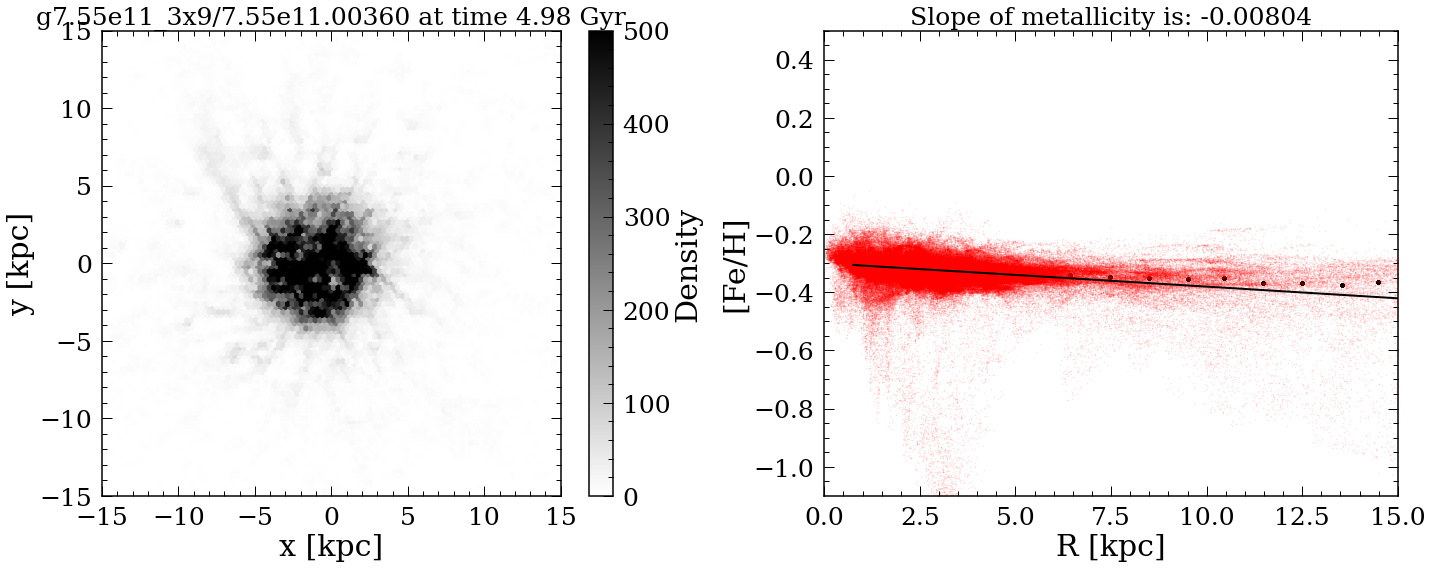

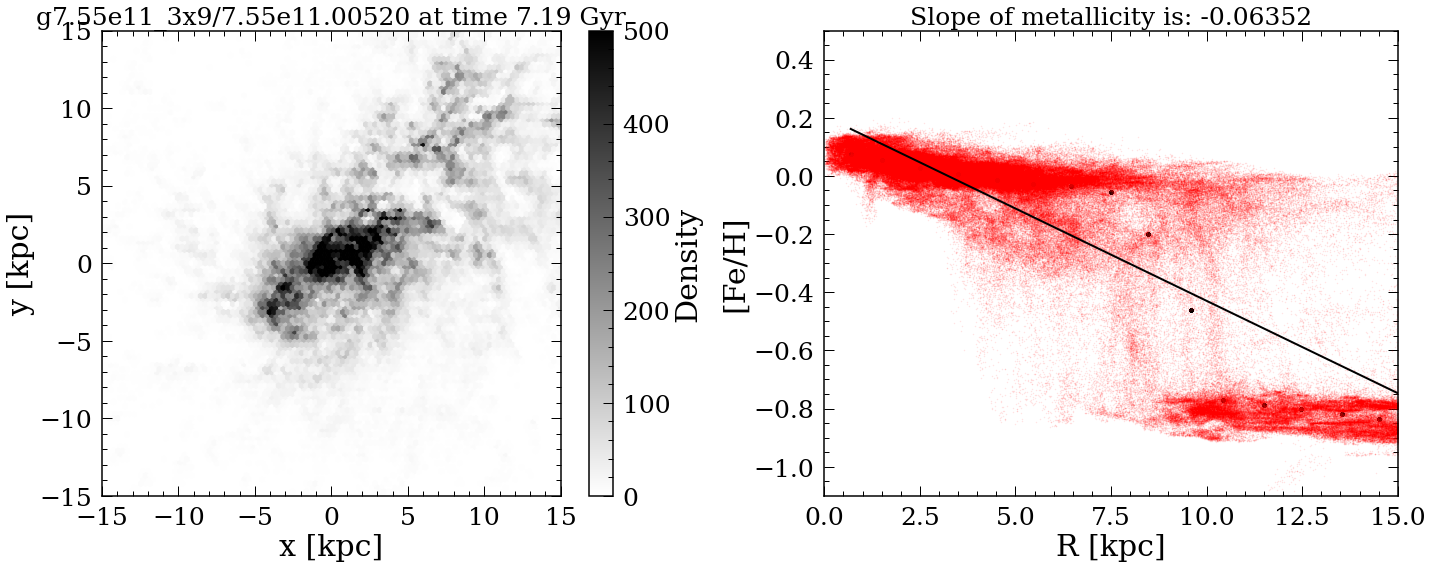

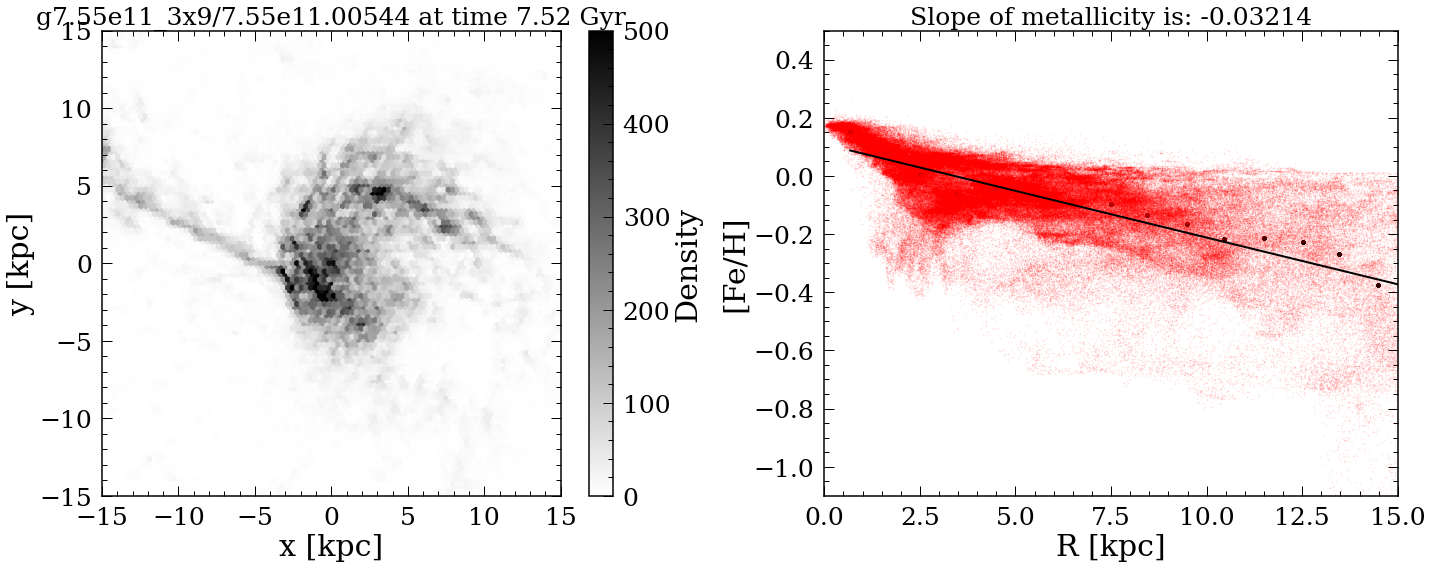

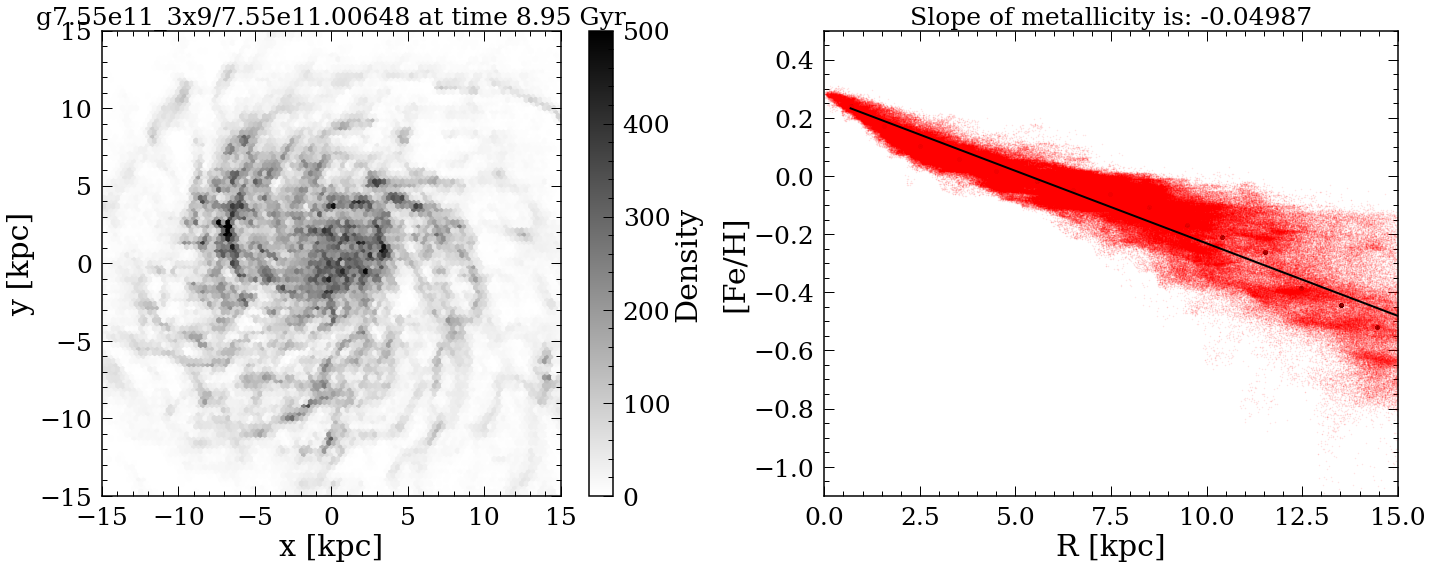

In [83]:
pltFehR_ISM(time2snap, 5, ylim=[-1.1,0.5])
pltFehR_ISM(time2snap, 7.2, ylim=[-1.1,0.5])
pltFehR_ISM(time2snap, 7.5, ylim=[-1.1,0.5])
pltFehR_ISM(time2snap, 9, ylim=[-1.1,0.5])


# Show our method works for all times 

In [84]:
def readsimdata(simNo,Rcut,Rcut_thread,zcut_thread,disk=True):
    if disk:
        data=pd.read_pickle('./g'+simNo+'_z_0_decomp.pkl')
    else:
        data=pd.read_pickle('./g'+simNo+'_z_0.pkl')
    data['R']=np.sqrt((data['x'])**2+data['y']**2)
    
    if Rcut:
        data=data.loc[data['Rbir']<Rcut_thread].reset_index(drop=True)
        data=data.loc[abs(data['zbir'])<zcut_thread].reset_index(drop=True)
    data['dR']=data['R']-data['Rbir']
    data['dz']=abs(data['z'])-abs(data['zbir'])
    if disk:
        data = data.loc[(data['decomp']==1)|(data['decomp']==4)].reset_index()
    return data

def normalize_data(data):
    return (data-np.mean(data))/np.std(data)

def train(y, X):
    """
    
    Args:
        y (array): An Nstar array of rotation periods.
        X (array): An Nstar x NX array of features.
        
    Returns:
        weights (array): The array of weights of length NX + 1.
        
    """
    A = np.concatenate((np.ones((len(X), 1)), X), axis=1)  # Shape: Nstars x Nfeatures (incl crossterms)
    AT = A.T
    ATA = np.dot(AT, A)
    
    weights = np.linalg.solve(ATA, np.dot(AT, y))
    return weights

def calcRbir_cv(data, fold=5):
    fold = int(fold)

    args = data['feh'], data['age']
    args_name = '[Fe/H]', 'τ'
    
    X = list(args)
    X_names = list(args_name)
    
    for a, b in combinations_with_replacement(args, 2):
        X.append(a * b)

    
    for a, b in combinations_with_replacement(args_name, 2):
        X_names.append(str(a + '*' + b))
        
    X = np.array(X).T


    # Define the number of training and validating stars.
    Ntest = int(1./float(fold)*np.shape(X)[0])
    y = data['Rbir'].values
    ypred = np.zeros(len(y))
    
    shuffle_inds = np.arange(len(y))
    np.random.shuffle(shuffle_inds)
        
    weights = np.zeros((len(X_names)+1, fold))
        
    for i in range(fold):
        if i == fold-1:
            startind = int(-Ntest)
            endind = int(len(shuffle_inds)-1)
        else:
            startind = int(i*Ntest)
            endind = int(Ntest*(i+1))
            
        train_inds = np.append(shuffle_inds[:startind],shuffle_inds[endind:])
        test_inds = shuffle_inds[startind:endind]
        y_train, X_train = y[train_inds], X[train_inds, :]
        y_test, X_test = y[test_inds], X[test_inds, :]

        weights[:, i] = train(y_train, X_train)

        A = np.concatenate((np.ones((len(X_test), 1)), X_test), axis=1)
        y_predict = np.dot(weights[:, i].T, A.T)
        ypred[test_inds] = y_predict

    return np.append(['$θ_C$'],X_names), [np.mean(weights[i,:]) for i in range(len(X_names)+1)], [np.std(weights[i,:]) for i in range(len(X_names)+1)], y, ypred

def calcRstd(data, Rbirbin=np.linspace(0,10,20)):
    Rbirs = np.zeros(len(Rbirbin)-1)
    Rstds = np.zeros(len(Rbirbin)-1)
    for i in range(len(Rbirbin)-1):
        data_loc = data.loc[(data['Rbir']>Rbirbin[i])&(data['Rbir']<Rbirbin[i+1])].reset_index(drop=True)
        Rstds[i] = np.std(data_loc['R']-data_loc['Rbir'])
        Rbirs[i] = (Rbirbin[i]+Rbirbin[i+1])/2
    return Rbirs, Rstds

def calcRstd_inf(infRbir, trueRbir, Rbirbin=np.linspace(0,10,20)):
    Rbirs = np.zeros(len(Rbirbin)-1)
    Rstds = np.zeros(len(Rbirbin)-1)
    for i in range(len(Rbirbin)-1):
        m = (trueRbir>Rbirbin[i])&(trueRbir<Rbirbin[i+1])
        Rstds[i] = np.std(trueRbir[m]-infRbir[m])
        Rbirs[i] = (Rbirbin[i]+Rbirbin[i+1])/2
    return Rbirs, Rstds

In [85]:
simsnames

['6.96e11', '8.26e11', '7.08e11', '1.12e12', '2.79e12', '7.55e11']

In [97]:
        
simNo='7.55e11'
Rcut=True
Rcut_thread=30
zcut_thread=2.5

print('Reading in simulation...')
data = readsimdata(simNo,Rcut,Rcut_thread,zcut_thread,disk=False)

data_premerg = data.loc[data['age']<6].reset_index(drop=True)
data_aftmerg = data.loc[data['age']>=8].reset_index(drop=True)
data_durmerg = data.loc[abs(data['age']-7)<1].reset_index(drop=True)
print('Finished reading in simulation...')

print('Calculating weights...')
allnames, weights, weights_err, y, ypred = calcRbir_cv(data_premerg)
allnames_am, weights_am, weights_err_am, y_am, ypred_am = calcRbir_cv(data_aftmerg)
allnames_dm, weights_dm, weights_err_dm, y_dm, ypred_dm = calcRbir_cv(data_durmerg)
print('Finished calculating weights...')

Reading in simulation...
Finished reading in simulation...
Calculating weights...
Finished calculating weights...


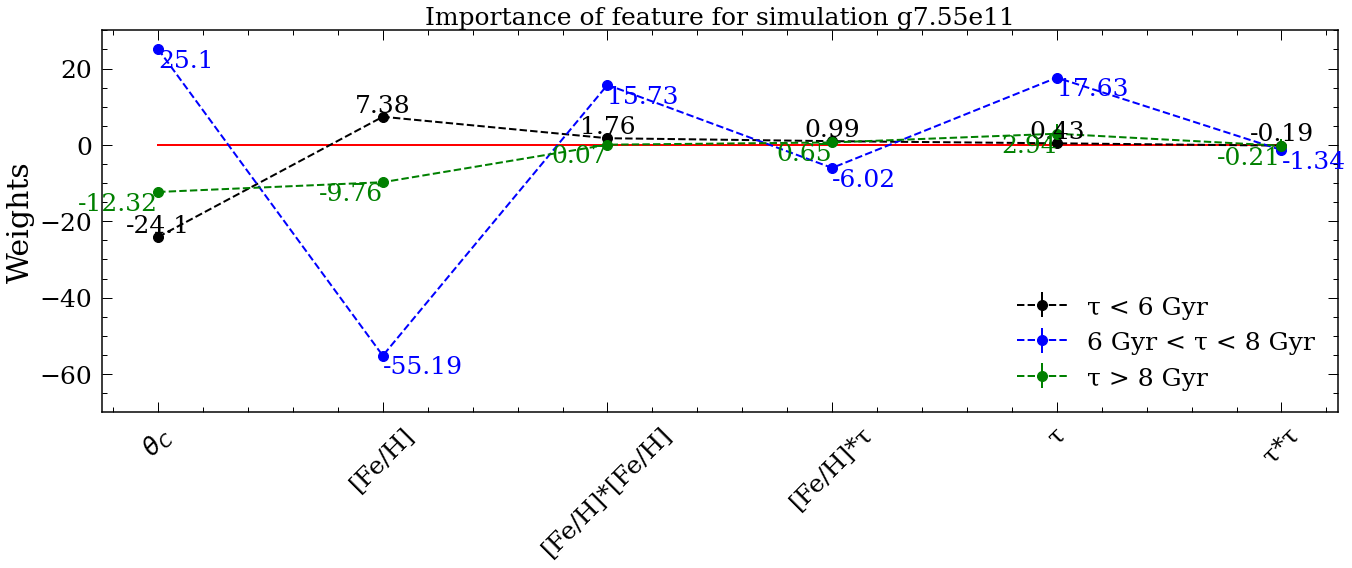

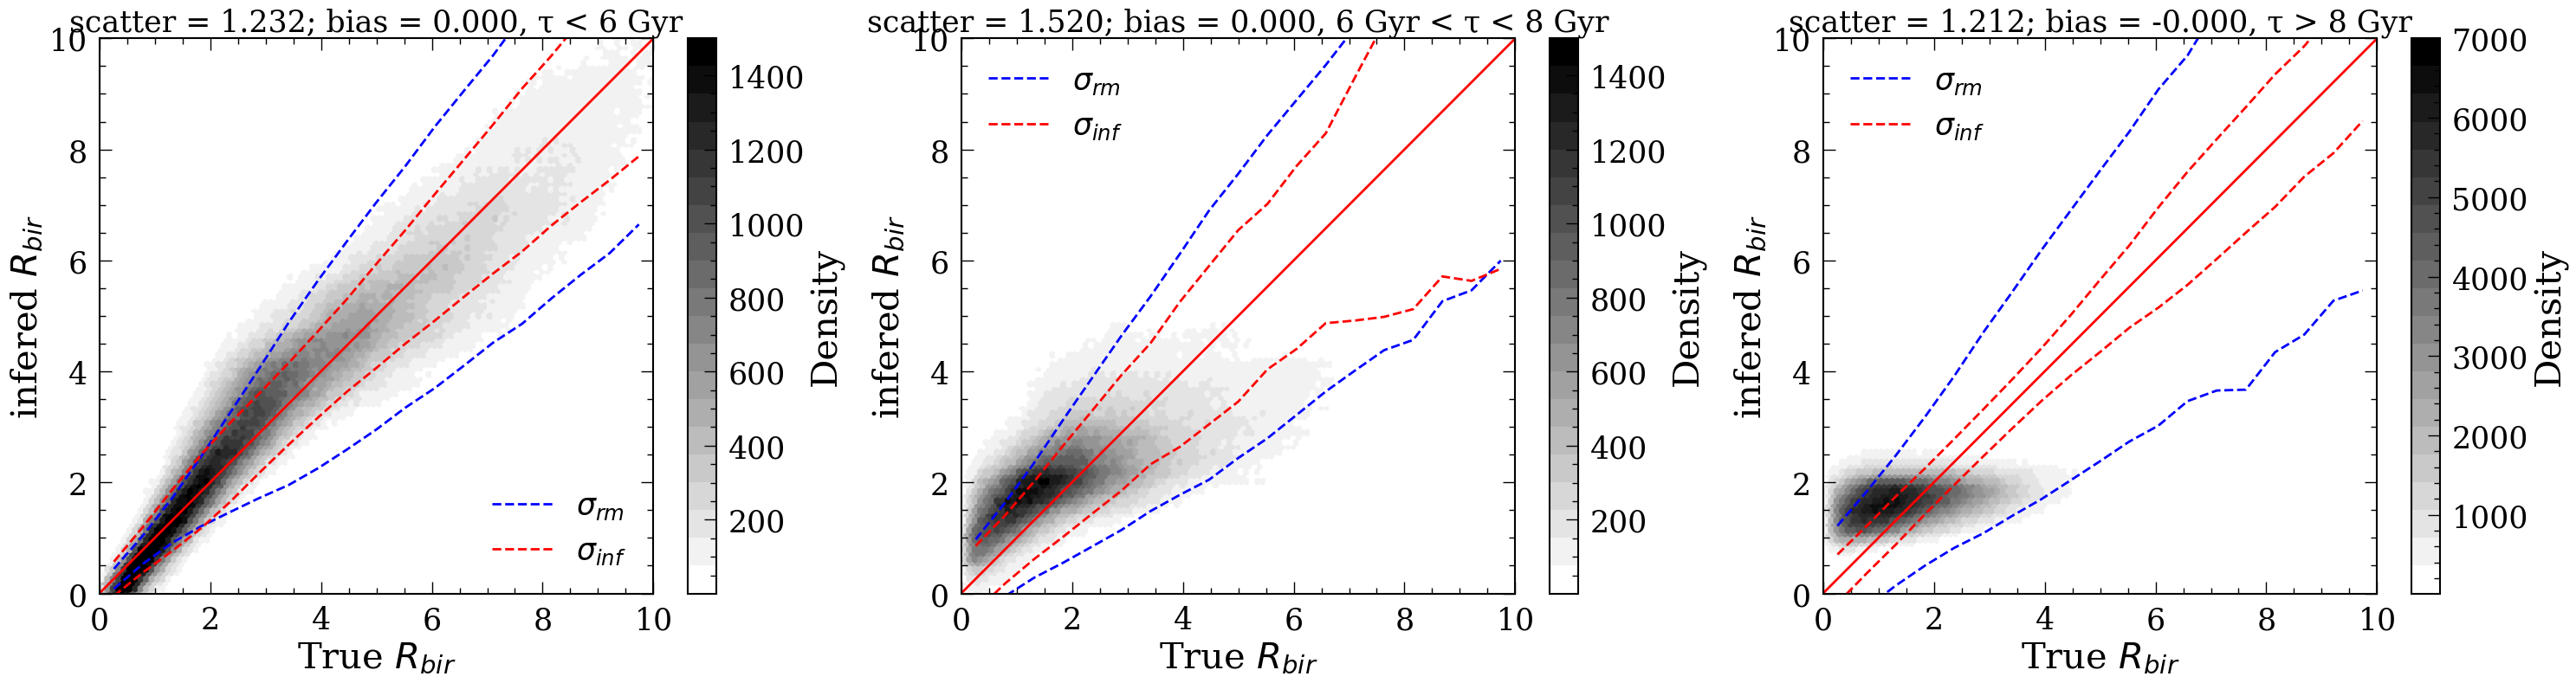

In [113]:
plt.figure(figsize=(19,8))
absweights, weights_imp, weights_imp_err, weights_imp_dm, weights_imp_err_dm, weights_imp_am, weights_imp_err_am, allnames = zip(*sorted(zip(abs(np.array(weights)), weights, weights_err, weights_dm, weights_err_dm, weights_am, weights_err_am, allnames)))
weights_imp, weights_imp_dm, weights_imp_am, allnames = weights_imp[::-1], weights_imp_dm[::-1], weights_imp_am[::-1], allnames[::-1]
plt.errorbar(range(len(allnames)), np.array(weights_imp), yerr=np.array(weights_imp_err), fmt='k--o', markersize=10, label='τ < 6 Gyr')
plt.errorbar(range(len(allnames)), np.array(weights_imp_dm), yerr=np.array(weights_imp_err_dm), fmt='b--o', markersize=10, label='6 Gyr < τ < 8 Gyr')
plt.errorbar(range(len(allnames)), np.array(weights_imp_am), yerr=np.array(weights_imp_err_am), fmt='g--o', markersize=10, label='τ > 8 Gyr')
plt.plot(range(len(allnames)),np.zeros(len(allnames)),'r-')
plt.xticks(range(len(allnames)), allnames, rotation=45)
plt.ylabel('Weights')
plt.ylim([-70,30])
plt.legend()
plt.title('Importance of feature for simulation g%s'%simsnames[i], fontsize=25)


for j, txt in enumerate(weights_imp):
    txt = np.round(txt,2)
    plt.annotate(txt, (j, weights_imp[j]),size=25,horizontalalignment='center', verticalalignment='bottom')
    
for j, txt in enumerate(weights_imp_dm):
    txt = np.round(txt,2)
    plt.annotate(txt, (j, weights_imp_dm[j]),size=25,horizontalalignment='left', verticalalignment='top', color='b')

for j, txt in enumerate(weights_imp_am):
    txt = np.round(txt,2)
    plt.annotate(txt, (j, weights_imp_am[j]),size=25,horizontalalignment='right', verticalalignment='top', color='g')
    
plt.tight_layout()
plt.savefig(simsnames[i]+'_importance.png')

xs = np.linspace(0, 30, 100)
plt.figure(figsize=(30,8), dpi=100)
plt.subplot(1,3,1)
scatter = np.std(y-ypred)
bias  = np.mean(y-ypred)
cmap = plt.cm.get_cmap('binary',20)
plt.hexbin(y, ypred, extent=(0,10,0,10),gridsize=100, mincnt=1, cmap=cmap,
          vmin=1, vmax=1500)
Rbirs, Rstds = calcRstd(data_premerg)
Rbirs_inf, Rstds_inf = calcRstd_inf(ypred, y)
plt.plot(Rbirs, Rbirs+Rstds, 'b--', label = '$σ_{rm}$')
plt.plot(Rbirs, Rbirs-Rstds, 'b--')
plt.plot(Rbirs_inf, Rbirs_inf-Rstds_inf, 'r--', label = '$σ_{inf}$')
plt.plot(Rbirs_inf, Rbirs_inf+Rstds_inf, 'r--')
plt.plot(xs, xs, "r-")
plt.xlim(0, 10)
plt.ylim(0, 10)
plt.xlabel("True $R_{bir}$")
plt.ylabel("infered $R_{bir}$")
plt.title('scatter = %.3f; bias = %.3f, τ < 6 Gyr'%(scatter, bias),fontsize=25)
plt.legend()
cb = plt.colorbar()
cb.set_label('Density')

plt.subplot(1,3,2)
scatter = np.std(y_dm-ypred_dm)
bias  = np.mean(y_dm-ypred_dm)
cmap = plt.cm.get_cmap('binary',20)
plt.hexbin(y_dm, ypred_dm, extent=(0,10,0,10),gridsize=100, mincnt=1, cmap=cmap,
          vmin=1, vmax=1500)
Rbirs, Rstds = calcRstd(data_durmerg)
Rbirs_inf, Rstds_inf = calcRstd_inf(ypred_dm, y_dm)
plt.plot(Rbirs, Rbirs+Rstds, 'b--', label = '$σ_{rm}$')
plt.plot(Rbirs, Rbirs-Rstds, 'b--')
plt.plot(Rbirs_inf, Rbirs_inf-Rstds_inf, 'r--', label = '$σ_{inf}$')
plt.plot(Rbirs_inf, Rbirs_inf+Rstds_inf, 'r--')
plt.plot(xs, xs, "r-")
plt.xlim(0, 10)
plt.ylim(0, 10)
plt.xlabel("True $R_{bir}$")
plt.ylabel("infered $R_{bir}$")
plt.title('scatter = %.3f; bias = %.3f, 6 Gyr < τ < 8 Gyr'%(scatter, bias),fontsize=25)
plt.legend()
cb = plt.colorbar()
cb.set_label('Density')


plt.subplot(1,3,3)
scatter_am = np.std(y_am-ypred_am)
bias_am  = np.mean(y_am-ypred_am)
cmap = plt.cm.get_cmap('binary',20)
plt.hexbin(y_am, ypred_am, extent=(0,10,0,10),gridsize=100, mincnt=10, cmap=cmap, 
           vmin=10, vmax=7000)
Rbirs_am, Rstds_am = calcRstd(data_aftmerg)
Rbirs_inf_am, Rstds_inf_am = calcRstd_inf(ypred_am, y_am)
plt.plot(Rbirs_am, Rbirs_am+Rstds_am, 'b--', label = '$σ_{rm}$')
plt.plot(Rbirs_am, Rbirs_am-Rstds_am, 'b--')
plt.plot(Rbirs_inf_am, Rbirs_inf_am-Rstds_inf_am, 'r--', label = '$σ_{inf}$')
plt.plot(Rbirs_inf_am, Rbirs_inf_am+Rstds_inf_am, 'r--')
plt.plot(xs, xs, "r-")
plt.xlim(0, 10)
plt.ylim(0, 10)
plt.xlabel("True $R_{bir}$")
plt.ylabel("infered $R_{bir}$")
plt.title('scatter = %.3f; bias = %.3f, τ > 8 Gyr'%(scatter_am, bias_am),fontsize=25)
plt.legend()
cb = plt.colorbar()
cb.set_label('Density')
plt.tight_layout()
    

In [115]:
pwd


'/data/users/llu'